In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 15 11:01:32 2022

@author: Simone
"""

import numpy as np 
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler
import pyproj
import json
from shapely.geometry import Point, mapping
from functools import partial
from shapely.ops import transform
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial.distance import cdist


%matplotlib notebook
pop = pd.read_csv("new/popSessoEtaLngLatSize2021.csv", dtype = {"ITTER107":str})
pop

,ITTER107,Territorio,Sesso,Età,Value,lng,lat,Size km2
0,1272,Torino,maschi,0 anni,2900,7.680687,45.073274,130.17
1,1272,Torino,femmine,0 anni,2724,7.680687,45.073274,130.17
2,1272,Torino,totale,0 anni,5624,7.680687,45.073274,130.17
3,1272,Torino,femmine,1 anni,2890,7.680687,45.073274,130.17
4,1272,Torino,maschi,1 anni,3015,7.680687,45.073274,130.17
...,...,...,...,...,...,...,...,...
2460235,IT111,Sud Sardegna,maschi,25 anni,1585,NaN,NaN,NaN
2460236,IT111,Sud Sardegna,femmine,91 anni,720,NaN,NaN,NaN
2460237,IT111,Sud Sardegna,femmine,23 anni,1330,NaN,NaN,NaN
2460238,IT111,Sud Sardegna,maschi,totale,169114,NaN,NaN,NaN


## Preprocessing

#### Get marital status

In [2]:
mar =  pd.read_csv("new/maritalStatus2020Agg2021.csv", dtype = {"ITTER107":str})
mar['ITTER107'] = mar['ITTER107'].str.lstrip('0')
mar = mar.astype({"Value": int})
mar

,ITTER107,Territorio,Sesso,Età,Stato civile,Value
0,IT,Italia,maschi,0 anni,nubile/celibe,212756
1,IT,Italia,maschi,0 anni,totale,212756
2,IT,Italia,femmine,0 anni,nubile/celibe,202218
3,IT,Italia,femmine,0 anni,totale,202218
4,IT,Italia,totale,0 anni,nubile/celibe,414974
...,...,...,...,...,...,...
11143435,41044,Pesaro,totale,totale,coniugata/o,44776
11143436,41044,Pesaro,totale,totale,divorziata/o,4109
11143437,41044,Pesaro,totale,totale,nubile/celibe,40387
11143438,41044,Pesaro,totale,totale,totale,96786


In [3]:
tot = pd.merge(pop, mar,how='outer',left_on=['ITTER107','Territorio','Sesso','Età'],right_on=['ITTER107','Territorio','Sesso','Età'],indicator=True)

In [4]:
tot = tot.drop(['Value_x','_merge'], axis=1)
tot= tot.rename(columns={'Value_y': 'Value'})
tot

,ITTER107,Territorio,Sesso,Età,lng,lat,Size km2,Stato civile,Value
0,1272,Torino,maschi,0 anni,7.680687,45.073274,130.17,nubile/celibe,3030
1,1272,Torino,maschi,0 anni,7.680687,45.073274,130.17,totale,3030
2,1272,Torino,femmine,0 anni,7.680687,45.073274,130.17,nubile/celibe,2905
3,1272,Torino,femmine,0 anni,7.680687,45.073274,130.17,totale,2905
4,1272,Torino,totale,0 anni,7.680687,45.073274,130.17,nubile/celibe,5935
...,...,...,...,...,...,...,...,...,...
11143435,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,totale,2901
11143436,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,divorziata/o,3
11143437,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,coniugata/o,5
11143438,IT111,Sud Sardegna,totale,20 anni,NaN,NaN,NaN,nubile/celibe,2893


In [5]:
tot = tot.loc[tot['ITTER107'].str.isdigit()] #No areas
tot = tot.loc[tot['Età'] != "totale"]
tot = tot.loc[tot['Sesso'] != "totale"]
tot = tot.loc[tot['Stato civile'] != "totale"]
try:
    tot['Età'] = tot['Età'].map(lambda x: x.rstrip(' anni'))
    tot['Età'] = tot['Età'].map(lambda x: x.rstrip(' anni e più'))
except:
    print("Already done")
tot['Età'] = tot['Età'].astype(int)
tot["ITTER107"] = pd.to_numeric(tot["ITTER107"]) #Can do because no areas

## Get only Lombardy

In [6]:
lombardy = pd.read_excel('new/Elenco-comuni-italiani.xls', sheet_name=0) #reads the first sheet of your excel file
lombardy = lombardy[lombardy['Denominazione Regione']=='Lombardia'] #Filtering dataframe
tot = pd.merge(tot, lombardy,how='inner',left_on=['ITTER107'],right_on=['Codice Comune formato alfanumerico']).drop(lombardy.columns,axis = 1)
tot

,ITTER107,Territorio,Sesso,Età,lng,lat,Size km2,Stato civile,Value
0,12133,Varese,maschi,0,8.822868,45.817017,54.93,nubile/celibe,264
1,12133,Varese,femmine,0,8.822868,45.817017,54.93,nubile/celibe,289
2,12133,Varese,femmine,1,8.822868,45.817017,54.93,nubile/celibe,240
3,12133,Varese,maschi,1,8.822868,45.817017,54.93,nubile/celibe,265
4,12133,Varese,maschi,2,8.822868,45.817017,54.93,nubile/celibe,297
...,...,...,...,...,...,...,...,...,...
1072267,15251,Vermezzo con Zelo,femmine,93,8.980580,45.396816,10.74,divorziata/o,0
1072268,15251,Vermezzo con Zelo,maschi,97,8.980580,45.396816,10.74,coniugata/o,0
1072269,15251,Vermezzo con Zelo,maschi,97,8.980580,45.396816,10.74,nubile/celibe,0
1072270,15251,Vermezzo con Zelo,maschi,97,8.980580,45.396816,10.74,vedova/o,0


In [7]:
# pd.set_option('display.max_rows', 10)
# tot.loc[(tot["Territorio"] == "Abbadia Lariana") & (tot["Stato civile"] == "coniugata/o")]

#### Create age groups and popul/km2

In [8]:
bins= [0,3,13,20,30,40,50,60,70,80,90,100,110]
labels = ['Infant','Kid','Teen','20s','30s','40s','50s','60s','70s','80s','90s','100s or older']
tot['AgeGroup'] = pd.cut(tot['Età'], bins=bins, labels=labels, right=False) ##Create age groups

#Gropu by age group
df = tot.groupby(['Territorio','Sesso','Stato civile','AgeGroup'], as_index=True).agg(
    {'Value':'sum','lat': 'first','lng':'first', 'Size km2':'first'}).reset_index()#["Value"].apply(lambda x : x.astype(int).sum()).to_frame(name = 'Value').reset_index()
df['populPerKm2'] = df['Value']/df['Size km2']
df = df.loc[df['populPerKm2'] > 10]#Filter out small villages
df

,Territorio,Sesso,Stato civile,AgeGroup,Value,lat,lng,Size km2,populPerKm2
101,Abbadia Lariana,femmine,coniugata/o,40s,171,45.900500,9.334549,17.09,10.005851
102,Abbadia Lariana,femmine,coniugata/o,50s,178,45.900500,9.334549,17.09,10.415448
123,Abbadia Lariana,femmine,nubile/celibe,20s,172,45.900500,9.334549,17.09,10.064365
150,Abbadia Lariana,maschi,coniugata/o,50s,175,45.900500,9.334549,17.09,10.239906
151,Abbadia Lariana,maschi,coniugata/o,60s,173,45.900500,9.334549,17.09,10.122879
...,...,...,...,...,...,...,...,...,...
144437,Zogno,maschi,coniugata/o,40s,352,45.794822,9.667919,34.86,10.097533
144438,Zogno,maschi,coniugata/o,50s,517,45.794822,9.667919,34.86,14.830752
144439,Zogno,maschi,coniugata/o,60s,447,45.794822,9.667919,34.86,12.822719
144457,Zogno,maschi,nubile/celibe,Kid,391,45.794822,9.667919,34.86,11.216294


In [9]:
# import seaborn as sns

# heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Clustering

In [10]:
from kmodes.kprototypes import KPrototypes

nClusters = 30 #30

# ss = StandardScaler()
# X = ss.fit_transform(df[['lng','lat']]) #'populPerKm2' per avere cluster di popolazione simile (non voluta)
# dfSliced = pd.concat([pd.DataFrame(X, columns = ['lng','lat']).reset_index(),df[['Sesso','Stato civile','AgeGroup']].reset_index()], axis = 1).drop(["index"], axis = 1)
# print(dfSliced)
dfSliced = df[['lng','lat','Sesso','Stato civile','AgeGroup']]

catColumnsPos = [dfSliced.columns.get_loc(col) for col in list(dfSliced.select_dtypes('object').columns)]
catColumnsPos += [dfSliced.columns.get_loc(col) for col in list(dfSliced.select_dtypes('category').columns)]
kprototype = KPrototypes(n_jobs = -1, n_clusters = nClusters, init = 'Huang', random_state = 0)
categories = kprototype.fit_predict(dfSliced, categorical = catColumnsPos)
df["cluster"] = categories


# ss = StandardScaler()
# X = ss.fit_transform(df[['lng','lat','Sesso','Stato civile','AgeGroup']]) #'populPerKm2' per avere cluster di popolazione simile (non voluta)
# #clustering = DBSCAN(eps=0.1, min_samples=10).fit(X)
# km = KMeans(n_clusters=15,init = 'k-means++', random_state=0, max_iter = 1000)#15
# clustering = km.fit(X)
# np.unique(clustering.labels_)

## Analyze clusters
##### By changing cluster number and see which people comprises

In [11]:
# for col in df.columns:
#     if df.columns.get_loc(col) < 4:
#         print(df.loc[df["cluster"] == selectedCluster][col].value_counts())

In [12]:
for i in range(0,nClusters):#For each cluster
    print("Cluster #" + str(i))
    for col in df.columns: #For each "important" column
        if (df.columns.get_loc(col) < 4) & (df.columns.get_loc(col) > 0):
            print(df.loc[df["cluster"] == i][col].astype(str).value_counts())
    print()#Whitespace

Cluster #0
femmine    837
Name: Sesso, dtype: int64
nubile/celibe    837
Name: Stato civile, dtype: int64
Kid    819
60s      9
70s      5
80s      4
Name: AgeGroup, dtype: int64

Cluster #1
femmine    900
Name: Sesso, dtype: int64
coniugata/o     878
divorziata/o     22
Name: Stato civile, dtype: int64
40s    900
Name: AgeGroup, dtype: int64

Cluster #2
femmine    913
Name: Sesso, dtype: int64
coniugata/o      825
divorziata/o      47
vedova/o          40
nubile/celibe      1
Name: Stato civile, dtype: int64
60s    913
Name: AgeGroup, dtype: int64

Cluster #3
femmine    228
Name: Sesso, dtype: int64
coniugata/o      222
nubile/celibe      5
divorziata/o       1
Name: Stato civile, dtype: int64
80s    228
Name: AgeGroup, dtype: int64

Cluster #4
femmine    775
Name: Sesso, dtype: int64
nubile/celibe    775
Name: Stato civile, dtype: int64
20s    775
Name: AgeGroup, dtype: int64

Cluster #5
femmine    308
Name: Sesso, dtype: int64
nubile/celibe    308
Name: Stato civile, dtype: int64
In

In [13]:
clusterNames = []
for i in range(0,nClusters):#For each cluster
    clusterName = ""
    for col in df.columns: #For each "important" column
        if (df.columns.get_loc(col) < 4) & (df.columns.get_loc(col) > 0):
            clusterName += df.loc[df["cluster"] == i][col].value_counts().idxmax() + " "
    clusterNames.append(clusterName)

In [14]:
clusterNames

['femmine nubile/celibe Kid ',
 'femmine coniugata/o 40s ',
 'femmine coniugata/o 60s ',
 'femmine coniugata/o 80s ',
 'femmine nubile/celibe 20s ',
 'femmine nubile/celibe Infant ',
 'femmine vedova/o 80s ',
 'maschi coniugata/o 80s ',
 'femmine vedova/o 70s ',
 'maschi coniugata/o 60s ',
 'maschi nubile/celibe 50s ',
 'maschi coniugata/o 70s ',
 'maschi coniugata/o 30s ',
 'femmine nubile/celibe 50s ',
 'femmine coniugata/o 20s ',
 'femmine coniugata/o 50s ',
 'maschi nubile/celibe Teen ',
 'maschi nubile/celibe Infant ',
 'femmine coniugata/o 70s ',
 'femmine nubile/celibe Teen ',
 'maschi divorziata/o 50s ',
 'femmine coniugata/o 30s ',
 'maschi nubile/celibe 30s ',
 'femmine nubile/celibe 40s ',
 'maschi coniugata/o 40s ',
 'maschi nubile/celibe Kid ',
 'femmine nubile/celibe 30s ',
 'maschi nubile/celibe 20s ',
 'maschi nubile/celibe 40s ',
 'maschi coniugata/o 50s ']

### Elbow method

In [15]:
# #Choose optimal K using Elbow method
# cost = []


# print(catColumnsPos)
# for cluster in range(10, 60):
#     try:
#         kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
#         kprototype.fit_predict(dfSliced, categorical = catColumnsPos)
#         cost.append(kprototype.cost_)
#         print('Cluster initiation: {}'.format(cluster))
#     except:
#         break
# # Converting the results into a dataframe and plotting them
# #Data viz

# %matplotlib inline
# plt.plot( range(2, 10), cost, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()
# #plt.savefig('elbow.png', dpi=fig.dpi)


## Visualization

In [15]:
# # Extract the data we're interested in
# lat = df['lat'].values
# lon = df['lng'].values
# population = df['Value'].values
# populationsqm = df['populPerKm2'].values
# #area = cities['area_total_km2'].values
selectedCluster = 8
lat = df.loc[df["cluster"] == selectedCluster]['lat'].values
lon = df.loc[df["cluster"] == selectedCluster]['lng'].values
population = df.loc[df["cluster"] == selectedCluster]['Value'].values
populationsqm = df.loc[df["cluster"] == selectedCluster]['populPerKm2'].values
area = df.loc[df["cluster"] == selectedCluster]['Size km2'].values

## Useful functions

In [16]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def getxyz(event):
    s = ax.format_coord(event.xdata, event.ydata)
    try:
        out = [float(x.split('=')[1].strip()) for x in s.split(',')]
    except:
        out = None
    return out

def onclick(event): #Need to zoom  a bit for it to work (????)
    out = getxyz(event)
    if out != None:
        az = ax.azim
        el = ax.elev
        if (abs(el) <= 2): #If elevation 0
            if (abs(az) <= 2 or abs(abs(az) -180) <= 2): # get z and not x
                zPt = out[2]
                latPt = out[1]
                closest = closest_point((zPt/100,latPt), list(zip(populationsqm/100, lat)))#Get closest point from picked
                tx = '%s' % (df.loc[(df["populPerKm2"] >= (closest[0]*100-0.1)) & 
                                    (df["populPerKm2"] <= (closest[0]*100+0.1))&
                                    (df["cluster"] == selectedCluster)&
                                    (df["lat"] == closest[1])]["Territorio"].values[0])
                ax.set_title(tx)
            elif (abs(az)-90 <= 2):# get z and not y
                zPt = out[2]
                lonPt = out[0]
                tx = out[0]
                closest = closest_point((zPt/100,lonPt), list(zip(populationsqm/100, lon)))#Get closest point from picked
                tx = '%s' % (df.loc[(df["populPerKm2"] >= (closest[0]*100-0.1)) & 
                                    (df["populPerKm2"] <= (closest[0]*100+0.1))&
                                    (df["cluster"] == selectedCluster)&
                                    (df["lng"] == closest[1])]["Territorio"].values[0])
                ax.set_title(tx)
            else:
                ax.set_title("Please adjust azimuth")
        elif (abs(el-90) <= 2):
            lonPt = out[0]#llcrnrlon+(urcrnrlon-llcrnrlon)/2 + event.xdata*((urcrnrlon-llcrnrlon)/2)/0.05481
            latPt = out[1]#llcrnrlat+(urcrnrlat-llcrnrlat)/2 + event.ydata*((urcrnrlat-llcrnrlat)/2)/0.05481
            closest = closest_point((lonPt,latPt), list(zip(lon, lat)))#Get closest point from picked
            tx = '%s' % (df.loc[(df["lng"] == closest[0])&
                                (df["cluster"] == selectedCluster)&
                                (df["lat"] == closest[1])]["Territorio"].values[0])
            ax.set_title(tx)
        else:
            ax.set_title("Please adjust elevation")

In [17]:
def kmRadius(c): #Define area of attractiveness
    point = Point(c)
    
    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )

    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(20_000)#Meters

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)
    dic = mapping(buffer_wgs84)
    return np.asarray(dic['coordinates'])[0]

##Mean based on: municipalities with more target population per sqmt influence more (can be **2 or **3)
##Remove far away points from calculation
def calculateWeightedMean(lat, lon, populationsqm):
    avLat = np.average(a=lat[clf > 0], weights=populationsqm[clf > 0]**3)
    avLon = np.average(a=lon[clf > 0], weights=populationsqm[clf > 0]**3)
    return avLon,avLat


## 3D map Lombardy

In [32]:
# for i in range (0, 4):
#     # Extract the data we're interested in
#     lat = df.loc[df["cluster"] == i]['lat'].values
#     lon = df.loc[df["cluster"] == i]['lng'].values
#     population = df.loc[df["cluster"] == i]['Value'].values
#     populationsqm = df.loc[df["cluster"] == i]['populPerKm2'].values
#     area = df.loc[df["cluster"] == i]['Size km2'].values
fig = plt.figure(0)
ax = fig.add_subplot(projection='3d')
print(clusterNames[selectedCluster])

llcrnrlat = 44
urcrnrlat = 47
llcrnrlon = 7
urcrnrlon = 12
# Create a basemap instance that draws the Earth layer
bm = Basemap(llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon, 
            urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon,
            projection='cyl', resolution='h', fix_aspect=False, ax=ax)
# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=-90, elev=90)
ax.set_xlabel('Longitude (°E)', labelpad=20)
ax.set_ylabel('Latitude (°N)', labelpad=20)
ax.set_zlabel('Population per sqkm', labelpad=20)
ax.set_zlim(0., 400)

colormap = np.arange(0,15)

from sklearn.ensemble import IsolationForest

clf = IsolationForest( random_state=0).fit_predict(np.array((lon,lat)).T)#Schema a blochi pptx

lonC, latC = calculateWeightedMean(lat, lon, populationsqm)
p = ax.scatter(lon, lat, (populationsqm), picker = True, s = area,c=colormap[clf])#Points # c=colormap[categories]
centers = ax.scatter(xs=lonC, ys=latC, edgecolor='black', c='white', marker = '*')#Centers

circle = kmRadius((lonC,latC))
r = ax.scatter(xs=circle[:,0], ys=circle[:,1], c='blue', marker = '1')#Radius

closest = closest_point((lonC,latC), list(zip(lon, lat)))#Get closest point from picked

tx = 'Center is located in: %s' % (df.loc[(df["lng"] == closest[0])&
                                          (df["cluster"] == selectedCluster)&
                                          (df["lat"] == closest[1])]["Territorio"].values[0])
ax.set_title(tx)
print(tx)
cid = fig.canvas.mpl_connect('button_press_event', onclick)#Get mouse click

fig.show

femmine vedova/o 70s 
Center is located in: Bresso


<bound method Figure.show of <Figure size 800x600 with 2 Axes>>

In [20]:
# df.loc[(df["cluster"] == selectedCluster) & (df["Territorio"] == "Lecco")]

## Elbow

In [21]:
# from scipy.spatial.distance import cdist

# distortions = []
# inertias = []
# mapping1 = {}
# mapping2 = {}
# K = range(2, 20)
 
# for k in K:
#     # Building and fitting the model
#     kmeanModel = KMeans(n_clusters=k).fit(X)
#     kmeanModel.fit(X)
 
#     distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                         'euclidean'), axis=1)) / X.shape[0])
#     inertias.append(kmeanModel.inertia_)
 
#     mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
#                                    'euclidean'), axis=1)) / X.shape[0]
#     mapping2[k] = kmeanModel.inertia_

In [22]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()

## Add transport (trains)

### Regionals

In [21]:
stops = pd.read_csv("new/Orario_Ferroviario_Regionale_-_Stops.csv")
stops= stops.drop(["stop_code","stop_id", "stop_desc", "stop_url", "location_type", "parent_station","location"],axis = 1)
stops

,stop_name,stop_lat,stop_lon
0,MOTTA S.DAMIANO,45.178212,9.221850
1,BOVISIO MASCIAGO-MOMBELLO,45.612041,9.141317
2,VAREDO,45.595605,9.153331
3,ORIO LITTA,45.166951,9.550633
4,BISUSCHIO-VIGGIU',45.870643,8.887910
...,...,...,...
422,LESA,45.825542,8.558806
423,MILANO ROMOLO,45.443351,9.167479
424,NOVARA FN,45.452082,8.626435
425,GALLIATE,45.481122,8.691409


In [22]:
def cutAwayMoreThanMinutes(stops):
#     avgTrainSpeed = 45 #km/h 
    #Remove if more than 1.5h
    #Remove from Colico and from Iseo
    point = stops.loc[stops["stop_name"] == "COLICO"]
    stops = stops.drop(stops[stops["stop_lat"] > point["stop_lat"].values[0]].index)#Prata Camportaccio
    stops = stops.drop(stops[(stops["stop_lat"] > point["stop_lat"].values[0]-0.1) & 
                       (stops["stop_lon"] > point["stop_lon"].values[0])].index)#Tirano
    point = stops.loc[stops["stop_name"] == "ISEO"]
    stops = stops.drop(stops[(stops["stop_lat"] > point["stop_lat"].values[0]) & 
                       (stops["stop_lon"] > point["stop_lon"].values[0])].index)#Cedegolo
    return stops


<IPython.core.display.Javascript object>


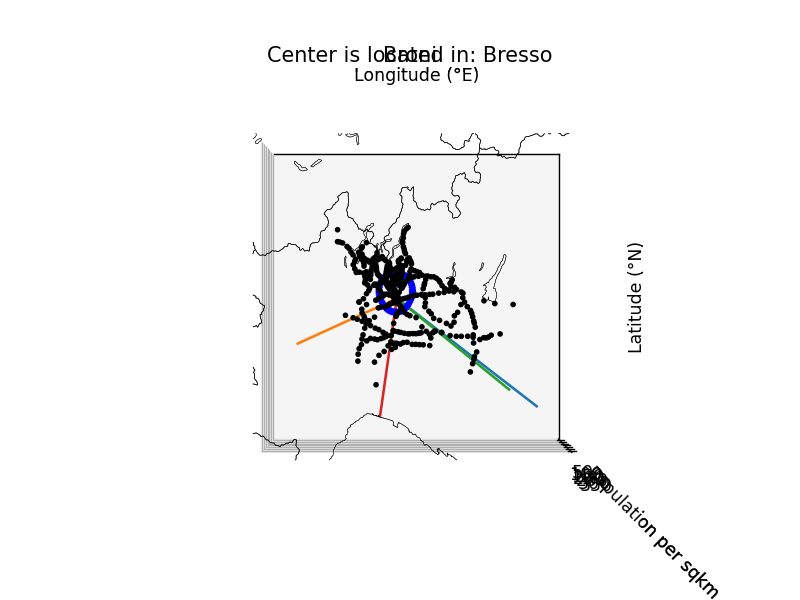

In [33]:
stops = cutAwayMoreThanMinutes(stops)
p.remove()
p = ax.scatter(xs=stops["stop_lon"], ys=stops["stop_lat"],marker = '.', c = "Black")#Centers
display(fig)  # Shows plot again

# r.remove()
# centers.remove()


## High speed

In [34]:
hs = pd.read_csv("new/Orario_Ferroviario_Frecce.csv")
hs

,stop_name,stop_lat,stop_lon
0,Bologna,44.494887,11.342616
1,Torino,45.070312,7.686857
2,Modena,44.648837,10.920087
3,Genova,44.405650,8.946256


<IPython.core.display.Javascript object>


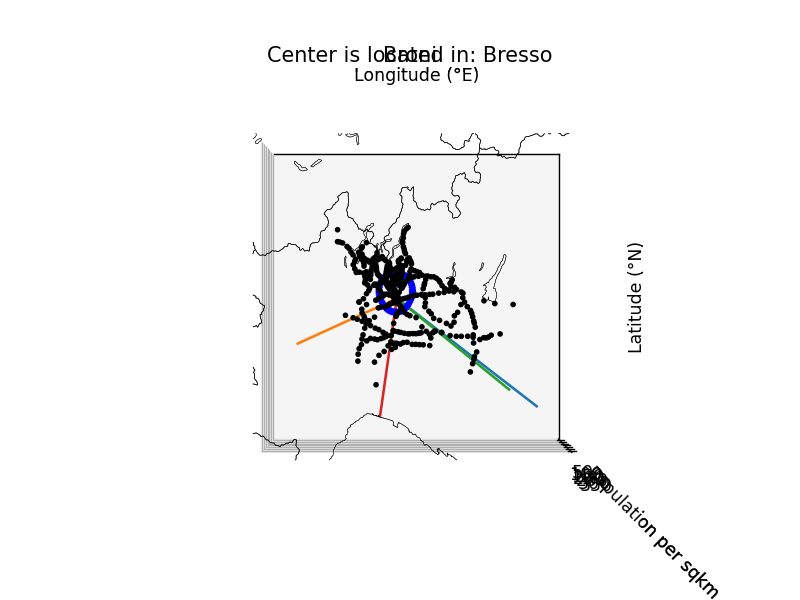

In [35]:
milano = stops.loc[stops["stop_name"] =="MILANO CENTRALE"]
for index, row in hs.iterrows():
    ax.plot([row["stop_lon"],milano["stop_lon"].values[0]], [row["stop_lat"],milano["stop_lat"].values[0]])

display(fig)  # Shows plot again


## IncomeS

In [ ]:
#TODO attach revenues to clustering